In [2]:
# import packages
import os
import cv2
import numpy as np;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
import albumentations as album
import math

from sklearn import model_selection
from scipy import ndimage
from typing import Tuple, List
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import joblib
import time

# Set seed (for reproducibility)
# num = 0
# torch.manual_seed(num)
# random.seed(num)
# np.random.seed(num)



class CaImagesDataset(Dataset):
    """CA Images dataset."""
    # load the dataset
    def __init__(self, x, y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    # number of samples in the dataset
    def __len__(self):
        return len(self.x)
    
    # get a sample from the dataset
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

def get_blobs_adaptive(img, bound_size, min_brightness_const, min_area):
    im_gauss = cv2.GaussianBlur(img, (5, 5), 0) # "smoothing" the image with Gaussian Blur
    thresh = cv2.adaptiveThreshold(im_gauss,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,bound_size,(min_brightness_const))
    # Find contours
    cont, hierarchy = cv2.findContours(thresh, 
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE # only stores necessary points to define contour (avoids redundancy, saves memory)
                            )
    cont_filtered = []
    for con in cont: 
        area = cv2.contourArea(con) # calculate area, filter for contours above certain size
        if area>min_area: # chosen by trial/error
            cont_filtered.append(con)    
    
    # Draw + fill contours
    new_img = np.full_like(img, 0) # image has black background
    for c in cont_filtered:
        cv2.drawContours(new_img, # image to draw on
                        [c], # contours to draw
                        -1, # contouridx: since negative, all contours are drawn
                        255, # colour of contours: white
                        -1 # thickness: since negative, fill in the shape
                        )
    return new_img, cont_filtered
  
def scale_data_scaler(data, opt):
  """Scales data with MinMaxScaler or StandardScaler
  data: list of data to scale
  opt: "minmax" or "stand" 
  
  Returns scaler and scaled data"""
  if (opt == "minmax"):
    print("minmax")
    scaler = MinMaxScaler(feature_range=(0,1))
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  elif (opt == "stand"):
    print("stand")
    scaler = StandardScaler()
    norm_data = [ lst[0] for lst in scaler.fit_transform(np.array(data).reshape((-1, 1)))]
  return scaler, norm_data

def scale_data(data, full:int):
  """Scales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns scaled data"""
  try:
    norm_data = [i/full for i in data]
  except:
    norm_data = data/full
  return norm_data

def unscale_data(data, full:int):
  """Unscales data with image dimensions
  data: list of data to scale
  full: image dimension (height or width)
  
  Returns unscaled data"""
  try:
      norm_data = [i*full for i in data]
  except:
      norm_data = data*full
  return np.array(norm_data)

def get_features_and_outcome(num_prev, neuron_positions, video, width, height):
  """Returns dataframe with features and outcome variables
  num_prev: number of previous frames to use as features
  neuron_positions: list of neuron positions (x, y)
  
  Returns dataframe with features and outcome variables"""
  i = 0
  features_x = []
  features_y = []
  
  # scale data (x or y position)
  norm_neuron_positions_x = scale_data([x for (x, y) in neuron_positions], full=width)
  norm_neuron_positions_y = scale_data([y for (x, y) in neuron_positions], full=height)
    
  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    # each loop = feature for one "sample" (num_prev previous points)
    features_x.append(norm_neuron_positions_x[i:i+num_prev])
    features_y.append(norm_neuron_positions_y[i:i+num_prev])
    i+=1

  # make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': norm_neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': norm_neuron_positions_y[num_prev:], 'curr_frame': [i for i in range(num_prev, len(neuron_positions))], 'video': [video for i in range(num_prev, len(neuron_positions))]
          } 
  df = pd.DataFrame(dict)
  return df

def get_norm_df(df, lst_cols:List, non_lst_cols: List):
  """Normalize dataframe values, even when some columns have elements that are lists

  df: dataframe to normalize
  lst_cols: list of columns where element dtype is list, not number
  non_lst_cols: list of columns where element dtype is number
  
  Returns dataframe with normalized columns"""
  df_expanded = df.copy()
  df_final = df.copy()
  for col in lst_cols:
      n = len(df_expanded[col][0])
      print(col, n)
      labels = [f"{col}_{i}" for i in range(n)]
      df_expanded[labels] = pd.DataFrame(df_expanded[col].tolist())
      df_expanded = df_expanded.drop(col, axis=1)
  
  scaler = MinMaxScaler()
  df_norm = pd.DataFrame(scaler.fit_transform(df_expanded),
                    columns=df_expanded.columns)
  
  for col_name in lst_cols:
      sub_cols = [col for col in df_norm.columns if col_name in col]
      df_final[col_name] = df_norm[sub_cols].values.tolist()
  df_final[non_lst_cols] = df_norm[non_lst_cols]

  return df_final

def get_features_and_outcome_w_visual(num_prev, max_height, max_width, neuron_positions, img_dir):
  """Returns dataframe with features and outcome variables
  num_prev: number of previous frames to use as features
  neuron_positions: list of neuron positions (x, y)
  
  Returns dataframe with features and outcome variables"""
  i = 0 # index of current frame
  features_x = []
  features_y = []
  features_x_colorhist = []
  features_x_mean= []
  features_x_meanstd = []
  PURPLE = (69, 6, 90)
  
  # scale data (x or y position)
  neuron_positions_x = [x for (x, y) in neuron_positions]
  neuron_positions_y = [y for (x, y) in neuron_positions]
    
  # since we need 10 previous frames as features, make sure we stop in time
  while i <= len(neuron_positions) - num_prev -1:
    frame = i+num_prev
    
    # Get features from image
    actx, acty = neuron_positions[frame]
    actx, acty = round(actx), round(acty)
    img_path = f"{img_dir}\{frame}.png"
    print(img_path)
    img= cv2.imread(img_path)
    img = cv2.copyMakeBorder(img, 0, max_height-img.shape[0], 0, max_width-img.shape[1], borderType=cv2.BORDER_CONSTANT, value=PURPLE) # Add padding
    crop_size=12

    
    cropped_img =  img[(acty)-crop_size:acty+crop_size, actx-crop_size:actx+crop_size, :]
    
    # Get visual features from cropped image (neuron)
    features_x_meanstd.append(np.concatenate(cv2.meanStdDev(cropped_img)).flatten()) # mean and std of each channel
    features_x_mean.append(cv2.mean(cropped_img)[:3]) # mean of each channel
    features_x_colorhist.append(cv2.calcHist([cropped_img],[0,1,2],None,[8,8,8],[0,256,0,256,0,256]).flatten()) # color histogram
    
    # Get features from neuron positions
    features_x.append(neuron_positions_x[i:frame])
    features_y.append(neuron_positions_y[i:frame])
    
    i+=1

  # Make dataframe with features and outcome variables
  dict = {'prev_n_x': features_x, 'curr_x': neuron_positions_x[num_prev:], 
          'prev_n_y': features_y, 'curr_y': neuron_positions_y[num_prev:], 
          'channel_means': features_x_mean, 'channel_std': features_x_meanstd
          } 

  # Normalize features
  scaler = MinMaxScaler()
  df = pd.DataFrame(dict)
  df_final = get_norm_df(df, ['prev_n_x', 'prev_n_y', 'channel_means', 'channel_std'], ['curr_x', 'curr_y'])
  
  df_final['curr_frame']= [j for j in range(num_prev, len(neuron_positions))]
  
  return df_final, scaler

def find_centroids(segmented_img):
  """Returns list of centroids of segmented image
  segmented_img: segmented image (binary)
  """
  centroids = []
  cont, hierarchy = cv2.findContours(segmented_img, 
                          cv2.RETR_EXTERNAL, 
                          cv2.CHAIN_APPROX_SIMPLE)
  for c in cont:
    # compute the center of the contour
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))
  
  return centroids

def get_dist_score(x, y, x2, y2):
  """Returns distance score between two points
  x, y: coordinates of point 1
  x2, y2: coordinates of point 2"""
  return math.sqrt(((x2-x)**2)+((y2-y)**2))

def get_closest_cent(centroids:List, pred:Tuple):
    """ Returns the closest centroid to the predicted coordinates
    centroids: list of centroids
    pred: predicted coordinates"""
    max_score = 10**1000
    predx, predy = pred
    coords = (0,0) # Closest to predicted coords

    for (pot_x, pot_y) in centroids:
        score = get_dist_score(predx, predy, pot_x, pot_y)
        print(f"Centroid: {pot_x}, {pot_y} | Score: {round(score)}")
        if score <= max_score:
            max_score = score
        coords = (pot_x, pot_y)
    return coords

def get_norm_width_height(video_dir, position_dir, videos, imgs_dct, positions_dct):
  width, height = 0, 0 
  for video in videos:
      # Save imgs and positions in dictionary
      imgs_dct[video] = np.load(rf"{video_dir}\{video}_crop.nd2.npy")
      positions_dct[video] = np.load(rf"{position_dir}\AVA_{video}.mat.npy")
      print(f"Loaded {video}")
      h, w = imgs_dct[video].shape[2:]
      if h > height:
          height = h
      if w > width:
          width = w
  return width, height


c:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# SET CONSTANTS
data_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\data"
model_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\models\lstm"
results_dir = r"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\lstm"

videos = ['11409', "11410", '11411', '11413', '11414', '11415']
imgs_dct = {}
positions_dct={}
width, height = get_norm_width_height( rf"{data_dir}\imgs", rf"{data_dir}\positions", videos, imgs_dct, positions_dct) # Get max height and width between all videos (for scaling)
print(f"Max width: {width} | Max height: {height}")
print(f"Finished loading images and positions: {len(imgs_dct)} images, {len(positions_dct)} positions")

# TRAIN MODEL
load=False
load_num=0
train=True
save_num=10

load2=False
load_num2=0
train2=True
save_num2=10


visual = False # Use visual features or not

# PREPARE DATA FOR LSTM
# Train-test split
df_train_lst = []
df_test_lst=[]

# Get features and outcome variables for each video
for video in videos:
    print(f"video {video} ...")
    positions = positions_dct[video]
    img_dir =rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}"
    if visual:
      video_df= get_features_and_outcome_w_visual(10, max_height=height, max_width=width, img_dir=img_dir, neuron_positions=positions)
    else:
      video_df= get_features_and_outcome(10, neuron_positions=positions, video=video, width=width, height=height)
    split = math.floor(len(video_df)*0.8)
    df_train_lst.append(video_df[:split])
    df_test_lst.append(video_df[split:])
print("Loaded data")

df_train = pd.concat(df_train_lst)
df_test = pd.concat(df_test_lst)

Loaded 11409
Loaded 11410
Loaded 11411
Loaded 11413
Loaded 11414
Loaded 11415
Max width: 454 | Max height: 546
Finished loading images and positions: 6 images, 6 positions
video 11409 ...
video 11410 ...
video 11411 ...
video 11413 ...
video 11414 ...
video 11415 ...
Loaded data


In [5]:
positions_dct["11409"]

array([[ 57.        , 466.        ],
       [ 58.42857143, 450.28571429],
       [ 58.5       , 434.        ],
       ...,
       [215.66666667, 143.88888889],
       [228.50016981, 139.82491722],
       [234.28571429, 140.        ]])

In [ ]:
norm_coords = []
for coord in positions_dct["11409"]:
  x, y = coord
  norm_x = 

In [6]:
def get_x_y(x, y):
    x_train_long = np.array(list(zip(x, y)))
    x_tr = []
    for row in x_train_long:
        x_tr.append(list(zip(row[0], row[1])))
    return x_tr

In [7]:
y_train_long = np.array(list(zip(df_train.curr_x.tolist(), df_train.curr_y.tolist())))
x_train_long = get_x_y(df_train.prev_n_x.tolist(), df_train.prev_n_y.tolist())

In [8]:
train_set = CaImagesDataset(x_train_long,y_train_long)
train_loader = DataLoader(train_set,
                          shuffle=True,
                          batch_size=256 # Each batch has 256 samples. (e.g. if dataset has 2048 samples total, there are 8 training batches)
                          )

In [9]:
class NeuralNetwork(nn.Module):
    """Neural network with LSTM layer and fully connected layer"""
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.lstm = nn.LSTM(input_size=2, 
                            hidden_size=2,# test other num
                            bidirectional=True,
                            num_layers=1,
                            batch_first=True
                            )
        # self.fc1 = nn.Linear(in_features=5,
        #                      out_features=2)

    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        # output = self.fc1(torch.relu(output))
        return output

# Training

In [10]:
model = joblib.load(rf"{model_dir}\lstm_model_16.pkl")

# Optimizer and loss function 
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.000001)
epochs = 500
existing_epochs=0
train_times = {} #key= epoch, value=loss for that epoch

In [11]:
for i in range(50):
    for j,data in enumerate(train_loader):
        input = data[0]
        y_actual = data[1].repeat(1, 2)
        y_pred = model(input)
        loss = criterion(y_pred,y_actual)
        loss.backward()
        optimizer.step()
    if i%10 == 0:
        print(i,"th iteration : ",loss)


0 th iteration :  tensor(0.0003, grad_fn=<MseLossBackward0>)
10 th iteration :  tensor(0.0002, grad_fn=<MseLossBackward0>)
20 th iteration :  tensor(0.0003, grad_fn=<MseLossBackward0>)
30 th iteration :  tensor(0.0006, grad_fn=<MseLossBackward0>)
40 th iteration :  tensor(0.0030, grad_fn=<MseLossBackward0>)


In [12]:
joblib.dump(model, rf"{model_dir}\lstm_model_19.pkl")

['C:\\Users\\hozhang\\Desktop\\CaTracking\\huayin_unet_lstm\\models\\lstm\\lstm_model_19.pkl']

# Testing

In [13]:
df_test

,prev_n_x,curr_x,prev_n_y,curr_y,curr_frame,video
2123,"[0.2744493392070485, 0.2870778267254039, 0.297...",0.449544,"[0.23846153846153845, 0.24053724053724054, 0.2...",0.300792,2133,11409
2124,"[0.2870778267254039, 0.29772393538913355, 0.31...",0.469455,"[0.24053724053724054, 0.2432844932844933, 0.24...",0.338871,2134,11409
2125,"[0.29772393538913355, 0.31057268722466963, 0.3...",0.485384,"[0.2432844932844933, 0.24633699633699635, 0.24...",0.367017,2135,11409
2126,"[0.31057268722466963, 0.3044730599796679, 0.31...",0.525207,"[0.24633699633699635, 0.24978867286559595, 0.2...",0.406752,2136,11409
2127,"[0.3044730599796679, 0.31644640234948596, 0.35...",0.553083,"[0.24978867286559595, 0.25071225071225073, 0.2...",0.433242,2137,11409
...,...,...,...,...,...,...
1495,"[0.18149779735682814, 0.17951541850220265, 0.1...",0.189427,"[0.10402930402930402, 0.1043956043956044, 0.10...",0.083726,1505,11415
1496,"[0.17951541850220265, 0.17753303964757713, 0.1...",0.189794,"[0.1043956043956044, 0.10402930402930402, 0.10...",0.082112,1506,11415
1497,"[0.17753303964757713, 0.177863436123348, 0.181...",0.190529,"[0.10402930402930402, 0.1043956043956044, 0.10...",0.080586,1507,11415
1498,"[0.177863436123348, 0.18149779735682814, 0.184...",0.192070,"[0.1043956043956044, 0.10402930402930402, 0.10...",0.079853,1508,11415


In [14]:
modelnum = 19
model = joblib.load(rf"{model_dir}\lstm_model_{modelnum}.pkl")
x_test = torch.Tensor(get_x_y(df_test.prev_n_x.tolist(), df_test.prev_n_y.tolist()))
y_test = np.array(list(zip(df_test.curr_x.tolist(), df_test.curr_y.tolist())))


In [15]:
test_pred = model(x_test)

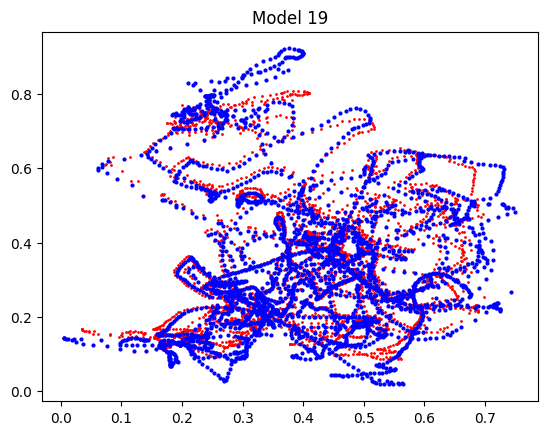

In [16]:
test_pred[:, [0, 1]].detach().numpy()
plt.plot((test_pred[:, 0].detach().numpy()+test_pred[:, 2].detach().numpy())/2, (test_pred[:, 1].detach().numpy()+test_pred[:, 3].detach().numpy())/2, 'ro', markersize = 1)
plt.title(f"Model {modelnum}")
plt.plot(y_test[:, 0], y_test[:, 1], 'bo', markersize = 2)

In [17]:
test_pred.shape # frames, then (forwardx, forwardy, backwardx, backwardy)
test_pred

tensor([[0.4534, 0.2620, 0.4388, 0.2791],
        [0.4647, 0.3037, 0.4557, 0.3074],
        [0.4864, 0.3311, 0.4762, 0.3524],
        ...,
        [0.1689, 0.1309, 0.1869, 0.1087],
        [0.1694, 0.1298, 0.1875, 0.1078],
        [0.1717, 0.1290, 0.1889, 0.1074]], grad_fn=<SliceBackward0>)

In [18]:
mean_test_pred = [((row[0]+row[2])/2, (row[1]+row[3])/2) for row in test_pred.detach().numpy()]
mean_test_pred

[(0.44613274931907654, 0.27055495977401733),
 (0.46019840240478516, 0.3055728077888489),
 (0.48129603266716003, 0.34176120162010193),
 (0.4962749481201172, 0.37448006868362427),
 (0.5370121002197266, 0.40775638818740845),
 (0.5603117942810059, 0.4440475106239319),
 (0.5772169232368469, 0.4396965503692627),
 (0.6027253270149231, 0.43963733315467834),
 (0.6193529367446899, 0.4178335964679718),
 (0.624157190322876, 0.414816677570343),
 (0.6344962120056152, 0.4035525918006897),
 (0.6442747116088867, 0.39778900146484375),
 (0.6512176990509033, 0.3914051055908203),
 (0.6576327085494995, 0.38489338755607605),
 (0.6617451906204224, 0.3816218972206116),
 (0.6631210446357727, 0.3763713836669922),
 (0.6642345786094666, 0.36688295006752014),
 (0.665616512298584, 0.35433924198150635),
 (0.6708579063415527, 0.3449637293815613),
 (0.6625047922134399, 0.34895822405815125),
 (0.6536926031112671, 0.34461215138435364),
 (0.6489565372467041, 0.33816593885421753),
 (0.6445050239562988, 0.3326343297958374),

In [19]:
scored_pred = []
correct_count = 0
incorrect_count = 0
for i in range(200):
    frame = df_test.curr_frame.tolist()[i]
    video = df_test.video.tolist()[i]
    print(f"Frame {frame} | Video {video}")
    actx, acty = unscale_data(df_test.curr_x.tolist()[i], width), unscale_data(df_test.curr_y.tolist()[i], height)
    pred_coord = unscale_data(mean_test_pred[i][0], width), unscale_data(mean_test_pred[i][1], height)
    # img = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}\{frame}.png", cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\{video}\{frame}.png", cv2.IMREAD_GRAYSCALE)
    cts = find_centroids(mask)
    min_score = 10*1000000
    min_act_score = 10*1000000
    print(cts)
    for ct in cts:
        score = get_dist_score(ct[0], ct[1], pred_coord[0], pred_coord[1])
        act_score = get_dist_score(ct[0], ct[1], actx, acty)
        if score < min_score:
            min_score = score
            closest_ct = ct
            print(f"Closest centroid: {closest_ct} | Score: {min_score}")
        if act_score < min_act_score:
            min_act_score = act_score
            closest_act_ct = ct
    if closest_act_ct == closest_ct:
        print("Correct!")
        correct_count += 1
    else:
        print("Incorrect")
        incorrect_count += 1
    scored_pred.append(closest_ct)
print(f"Correct: {correct_count} | Incorrect: {incorrect_count}")

Frame 2133 | Video 11409
[(195, 387), (175, 317), (203, 166), (182, 166)]
Closest centroid: (195, 387) | Score: 239.39589567405324
Closest centroid: (175, 317) | Score: 171.50331401562622
Closest centroid: (203, 166) | Score: 18.282672854688325
Correct!
Frame 2134 | Video 11409
[(194, 394), (169, 327), (213, 186), (193, 185)]
Closest centroid: (194, 394) | Score: 227.64736319793676
Closest centroid: (169, 327) | Score: 165.0598516133626
Closest centroid: (213, 186) | Score: 19.584800295482875
Correct!
Frame 2135 | Video 11409
[(163, 339), (223, 205), (203, 204)]
Closest centroid: (163, 339) | Score: 162.19263164768705
Closest centroid: (223, 205) | Score: 18.938717268117443
Correct!
Frame 2136 | Video 11409
[(156, 349), (215, 223), (233, 221)]
Closest centroid: (156, 349) | Score: 160.29272164872484
Closest centroid: (215, 223) | Score: 21.20793962604302
Closest centroid: (233, 221) | Score: 18.23522473433563
Correct!
Frame 2137 | Video 11409
[(149, 356), (230, 241), (246, 237)]
Closes

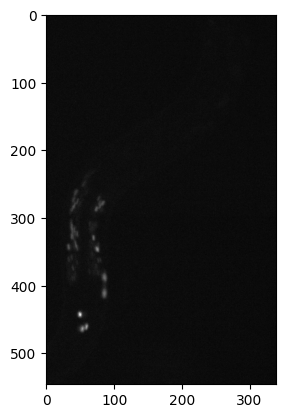

In [31]:
img = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\11409\0.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

torch.Size([1, 546, 340])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


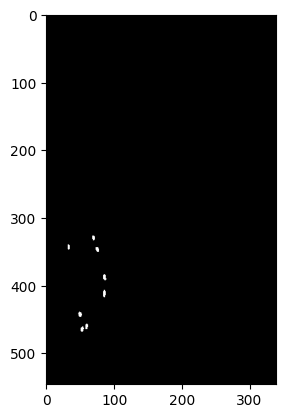

In [40]:
import torchvision.transforms as transforms
import cv2
og_mask = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\11409\0.png")
mask = cv2.cvtColor(og_mask, cv2.COLOR_BGR2GRAY)
mask = transforms.ToTensor()(mask)
print(mask.shape)
print(mask)
plt.imshow(mask.detach().numpy()[0], cmap='gray')
get_max_val(mask)

torch.Size([1, 546, 546])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


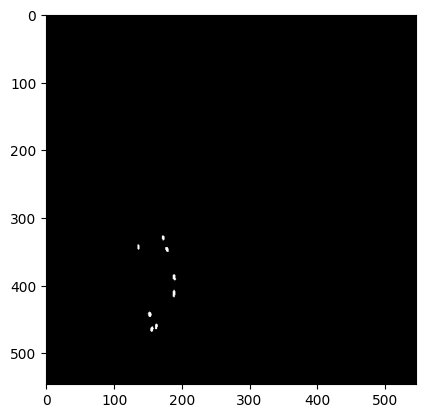

In [41]:
width = 340
height = 546
max_dim = max(512, width, height)
pad_left = (max_dim-width)//2
pad_right = max_dim-width-pad_left
pad_top = (max_dim-height)//2
pad_bottom = max_dim-height-pad_top
mask = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), 
                                            padding_mode='edge')(mask)
print(mask.shape)
print(mask)
plt.imshow(mask.detach().numpy()[0], cmap='gray')
get_max_val(mask)

In [70]:
def get_max_val(mask):
    max_vals = [max(row) for row in mask.detach().numpy()[0]]
    return max(max_vals)

def get_min_val(mask):
    min_vals = [min(row) for row in mask.detach().numpy()[0]]
    return min(min_vals)

215 30


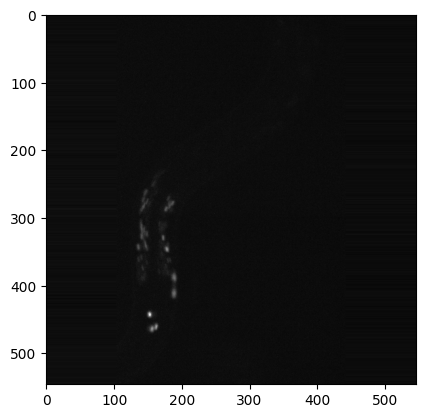

In [75]:
import torchvision.transforms as transforms
import cv2
og_mask = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\11409\0.png")
mask = cv2.cvtColor(og_mask, cv2.COLOR_BGR2GRAY)
print(max([max(row) for row in mask]), min([min(row) for row in mask]))
mask = transforms.ToTensor()(mask)
width = 340
height = 546
max_dim = max(512, width, height)
pad_left = (max_dim-width)//2
pad_right = max_dim-width-pad_left
pad_top = (max_dim-height)//2
pad_bottom = max_dim-height-pad_top
mask = transforms.Pad(padding=(pad_left, pad_top, pad_right, pad_bottom), 
                                            padding_mode='edge')(mask)
plt.imshow(mask.detach().numpy()[0], cmap='gray')

0.84313726 0.11764706


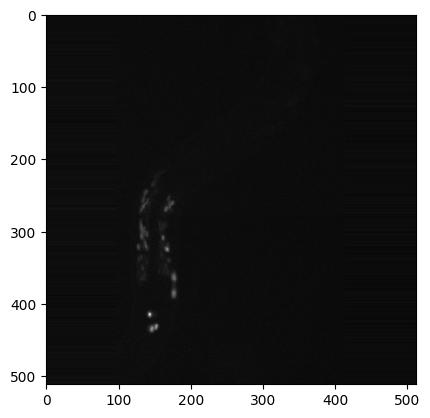

In [76]:
%matplotlib inline
mask = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT ,size=(512, 512))(mask)
plt.imshow(mask.detach().numpy()[0], cmap='gray')
print(max([max(row) for row in mask.detach().numpy()[0]]), min([min(row) for row in mask.detach().numpy()[0]]))


(0.6862745, -0.7647059)

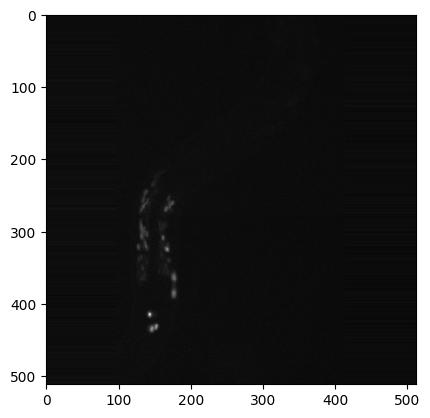

In [77]:
mask = transforms.Normalize(mean=(0.5), std=(0.5))(mask)
plt.imshow(mask.detach().numpy()[0], cmap='gray')
get_max_val(mask), get_min_val(mask)

(546, 340)
(546, 340, 3)


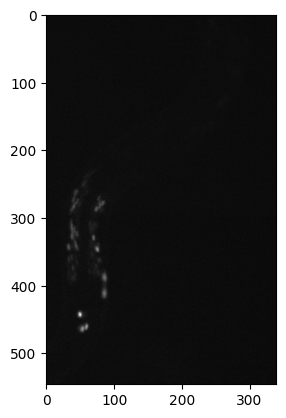

In [58]:
og_img = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\11409\0.png")
img = cv2.cvtColor(og_img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
print(img.shape)
print(og_img.shape)

In [25]:
print(img)

[[40 41 38 ... 38 40 39]
 [40 40 39 ... 39 40 38]
 [40 39 39 ... 40 38 39]
 ...
 [42 40 41 ... 37 37 38]
 [42 40 42 ... 40 39 40]
 [41 41 39 ... 39 38 38]]


In [26]:
scored_pred

[(203, 166),
 (213, 186),
 (223, 205),
 (233, 221),
 (246, 237),
 (256, 236),
 (257, 244),
 (269, 239),
 (286, 222),
 (284, 233),
 (290, 230),
 (294, 226),
 (299, 223),
 (302, 221),
 (304, 218),
 (306, 215),
 (309, 209),
 (308, 190),
 (302, 188),
 (297, 186),
 (294, 183),
 (292, 180),
 (289, 178),
 (293, 175),
 (291, 172),
 (288, 167),
 (283, 159),
 (277, 153),
 (269, 146),
 (259, 138),
 (250, 130),
 (243, 122),
 (236, 114),
 (232, 107),
 (227, 117),
 (228, 110),
 (230, 102),
 (239, 87),
 (242, 96),
 (244, 110),
 (246, 121),
 (247, 133),
 (249, 143),
 (253, 141),
 (257, 134),
 (262, 128),
 (253, 136),
 (264, 114),
 (268, 111),
 (271, 113),
 (281, 116),
 (283, 117),
 (287, 120),
 (291, 124),
 (296, 129),
 (282, 137),
 (290, 143),
 (316, 162),
 (320, 176),
 (321, 190),
 (306, 191),
 (305, 204),
 (303, 216),
 (301, 226),
 (299, 235),
 (299, 242),
 (303, 249),
 (310, 254),
 (317, 259),
 (325, 263),
 (331, 267),
 (332, 269),
 (329, 270),
 (319, 272),
 (308, 274),
 (318, 273),
 (308, 272),
 

In [27]:
mean_test_pred[max(0, i-10):i+1]

[(0.5991896390914917, 0.433892160654068),
 (0.5773847699165344, 0.44438761472702026),
 (0.5560804009437561, 0.45218682289123535),
 (0.5396125316619873, 0.45951223373413086),
 (0.5210632085800171, 0.4700348973274231),
 (0.5096187591552734, 0.47503262758255005),
 (0.5256052017211914, 0.47215062379837036),
 (0.5566973686218262, 0.4866870641708374),
 (0.5521265864372253, 0.49119997024536133),
 (0.5645378232002258, 0.48345181345939636),
 (0.5766614079475403, 0.49139589071273804)]

In [28]:
i=41
unscale_data([x for (x, y) in mean_test_pred[max(0, i-10):i+1]], width)
unscale_data([y for (x, y) in mean_test_pred[max(0, i-10):i+1][1]], height)

TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
for i in range(200):
    frame = df_test.curr_frame.tolist()[i]
    video = df_test.video.tolist()[i]
    print(f"Frame {frame} | Video {video}")
    tail=10
    img = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}\{frame}.png", cv2.IMREAD_GRAYSCALE)
    plt.imshow(img)
    plt.plot(unscale_data(df_test.curr_x.tolist()[max(0, i-10):i+1], width), unscale_data(df_test.curr_y.tolist()[max(0, i-10):i+1], height), 'bo', markersize = 2, label="Actual") # 
    plt.plot(unscale_data([x for (x, y) in mean_test_pred[max(0, i-10):i+1]], width), unscale_data([y for (x, y) in mean_test_pred[max(0, i-10):i+1]], height), 'mo', markersize = 2, label="Predicted") # 
    # plt.plot(unscale_data(test_pred[i-tail:i+1, 0].detach().numpy(), width), unscale_data(test_pred[i-tail:i+1, 1].detach().numpy(), height), 'yo', markersize = 1, label="Forward")
    # plt.plot(unscale_data(test_pred[i-tail:i+1, 2].detach().numpy(), width), unscale_data(test_pred[i-tail:i+1, 3].detach().numpy(), height), 'go', markersize = 1, label="Backward")
    print(f"Predicted: {pred_coord} | Actual: {actx, acty} | Selected: {scored_pred[i]}")
    plt.plot([x for (x,y) in scored_pred[i-10:i+1]], [y for (x,y) in scored_pred[i-10:i+1]], 'co', markersize = 2, label="Selected")
    plt.legend()
    plt.savefig(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\lstmimgs\{video}_{frame}.png")
    plt.close()

Frame 2133 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (203, 166)
Frame 2134 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (213, 186)
Frame 2135 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (223, 205)
Frame 2136 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (233, 221)
Frame 2137 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (246, 237)
Frame 2138 | Video 11409
Predicted: (array(283.36747265), array(226.48997104)) | Actual: (array(295.83333333), array(221.83333333)) | Selected: (256, 236)
Frame 2139 | Video 11409
Predicted: (array(283.36747265), array(226.48

In [ ]:
plt.plot((test_pred[:, 0].detach().numpy()+test_pred[:, 2].detach().numpy())/2, (test_pred[:, 1].detach().numpy()+test_pred[:, 3].detach().numpy())/2, 'ro', markersize = 1)
plt.title(f"Model {modelnum}")
plt.plot(y_test[:, 0], y_test[:, 1], 'bo', markersize = 2)

In [ ]:
df_test.reset_index(inplace=True)
df_test # 2954 rows

,index,prev_n_x,curr_x,prev_n_y,curr_y,curr_frame,video
0,2123,"[0.2744493392070485, 0.2870778267254039, 0.297...",0.449544,"[0.23846153846153845, 0.24053724053724054, 0.2...",0.300792,2133,11409
1,2124,"[0.2870778267254039, 0.29772393538913355, 0.31...",0.469455,"[0.24053724053724054, 0.2432844932844933, 0.24...",0.338871,2134,11409
2,2125,"[0.29772393538913355, 0.31057268722466963, 0.3...",0.485384,"[0.2432844932844933, 0.24633699633699635, 0.24...",0.367017,2135,11409
3,2126,"[0.31057268722466963, 0.3044730599796679, 0.31...",0.525207,"[0.24633699633699635, 0.24978867286559595, 0.2...",0.406752,2136,11409
4,2127,"[0.3044730599796679, 0.31644640234948596, 0.35...",0.553083,"[0.24978867286559595, 0.25071225071225073, 0.2...",0.433242,2137,11409
...,...,...,...,...,...,...,...
2949,1495,"[0.18149779735682814, 0.17951541850220265, 0.1...",0.189427,"[0.10402930402930402, 0.1043956043956044, 0.10...",0.083726,1505,11415
2950,1496,"[0.17951541850220265, 0.17753303964757713, 0.1...",0.189794,"[0.1043956043956044, 0.10402930402930402, 0.10...",0.082112,1506,11415
2951,1497,"[0.17753303964757713, 0.177863436123348, 0.181...",0.190529,"[0.10402930402930402, 0.1043956043956044, 0.10...",0.080586,1507,11415
2952,1498,"[0.177863436123348, 0.18149779735682814, 0.184...",0.192070,"[0.1043956043956044, 0.10402930402930402, 0.10...",0.079853,1508,11415


In [ ]:
start = 2000
end = 3000
tail = 10
for i in range(start, end+1):
    video = df_test.iloc[i].video
    frame= df_test.iloc[i].curr_frame
    img = cv2.cvtColor(cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}\{frame}.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Video 11410 Frame {i+2132}")
    plt.plot(unscale_data(data=((test_pred[i-tail:i+1, 0].detach().numpy()+test_pred[i-tail:i+1, 2].detach().numpy())/2), full=width), 
            unscale_data(data=(test_pred[i-tail:i+1, 1].detach().numpy()+test_pred[i-tail:i+1, 3].detach().numpy())/2, full=height), 'ro', markersize = 1)
    plt.plot(unscale_data(test_pred[i-tail:i+1, 0].detach().numpy(), width), unscale_data(test_pred[i-tail:i+1, 1].detach().numpy(), height), 'yo', markersize = 1)
    plt.plot(unscale_data(test_pred[i-tail:i+1, 2].detach().numpy(), width), unscale_data(test_pred[i-tail:i+1, 3].detach().numpy(), height), 'go', markersize = 1)
    plt.plot(unscale_data(y_test[i-tail:i+1, 0], width), unscale_data(y_test[i-tail:i+1, 1], height), 'bo', markersize = 2)
    plt.savefig(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\bothimg\tail\test_{i}.png")
    plt.close()
    print(f"Saved {i-start+1} out of {end-start+1} images | {round((i/(end-start))*100, 2)}% done")
    # plt.ylim([0, 1])
    # plt.ylim([0, 1])
    # plt.show()

# Pipeline Test

In [ ]:
modelnum = 12
model = joblib.load(rf"{model_dir}\lstm_model_{modelnum}.pkl")


In [ ]:
positions_dct[video]

array([[252.5       , 316.5       ],
       [260.52788462, 316.72382514],
       [275.62019231, 293.24690206],
       ...,
       [ 86.5       ,  44.        ],
       [ 87.2       ,  43.6       ],
       [ 88.        ,  43.        ]])

In [ ]:
video = '11409'


tensor([0.1582, 0.5741], grad_fn=<DivBackward0>)
(46, 319) | Score: 26
(51, 314) | Score: 21
(42, 295) | Score: 35
(101, 271) | Score: 52
(131, 238) | Score: 96
(143, 223) | Score: 115
(51, 314) Chosen
(46, 319) Actual


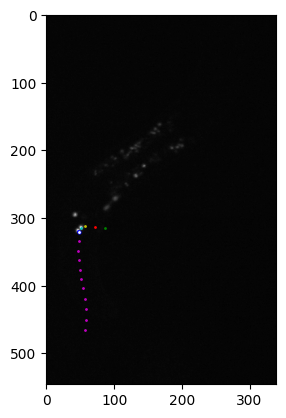

In [ ]:
y = [scale_data(y, height) for x, y in positions_dct[video]]
x = [scale_data(x, width) for x, y in positions_dct[video]]
frame = 10
all_x = x[frame-10:frame]
all_y = y[frame-10:frame]
input_x = np.array(all_x).reshape(1, -1).tolist()
input_y = np.array(all_y).reshape(1, -1).tolist()
actx, acty = positions_dct[video][frame]
input_x_y = torch.Tensor(get_x_y(input_x, input_y))
pred_frame = model(input_x_y)[0]
pred_forward = pred_frame[:2]
pred_backward = pred_frame[2:]
pred_mean = (pred_forward+pred_backward)/2
img = cv2.cvtColor(cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}\{frame}.png"), cv2.COLOR_BGR2GRAY)
mask = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\{video}\{frame}.png", cv2.IMREAD_GRAYSCALE)
cts = find_centroids(mask)
plt.imshow(img, cmap='gray')
plt.plot(unscale_data(data=pred_mean[0].detach().numpy(), full=width), unscale_data(data=pred_mean[1].detach().numpy(), full=height), 'ro', markersize = 1)
plt.plot(unscale_data(data=pred_forward[0].detach().numpy(), full=width), unscale_data(data=pred_forward[1].detach().numpy(), full=height), 'yo', markersize = 1)
plt.plot(unscale_data(data=pred_backward[0].detach().numpy(), full=width), unscale_data(data=pred_backward[1].detach().numpy(), full=height), 'go', markersize = 1)
plt.plot(actx, acty, 'bo', markersize = 2)
for (x,y) in input_x_y[0]:
    plt.plot(unscale_data(x, width), unscale_data(y, height), 'mo', markersize = 1)
print(pred_mean)
pred_mean = unscale_data(float(pred_mean[0]), width), unscale_data(float(pred_mean[1]), height)
min_score = 10*100000
min_act_score = 10%100000
for ct in cts:
    score = get_dist_score(pred_mean[0], pred_mean[1], ct[0], ct[1])
    act_score = get_dist_score(actx, acty, ct[0], ct[1])
    if score < min_score:
        min_score = score
        chosen = ct
    if act_score < min_act_score:
        min_act_score = act_score
        chosen_act = ct
    print(f"{ct} | Score: {round(score)}")
print(f"{chosen} Chosen")
print(f"{chosen_act} Actual")

plt.plot(chosen[0], chosen[1], 'co', markersize = 1)
plt.plot(chosen_act[0], chosen_act[1], 'bo', markersize = 1)
plt.plot(actx, acty, 'wo', markersize = 1)


In [ ]:
start=10
all_y = [scale_data(y, height) for x, y in positions_dct[video]]
all_x = [scale_data(x, width) for x, y in positions_dct[video]]
listed_x = all_x[start-10:start]
listed_y = all_y[start-10:start]
for frame in range(start, 30):    
    input_x = np.array(listed_x).reshape(1, -1).tolist()
    input_y = np.array(listed_y).reshape(1, -1).tolist()
    actx, acty = positions_dct[video][frame]
    input_x_y = torch.Tensor(get_x_y(input_x, input_y))
    pred_frame = model(input_x_y)[0]
    pred_forward = pred_frame[:2]
    pred_backward = pred_frame[2:]
    pred_mean = (pred_forward+pred_backward)/2
    img = cv2.cvtColor(cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\{video}\{frame}.png"), cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\ground_truth\{video}\{frame}.png", cv2.IMREAD_GRAYSCALE)
    cts = find_centroids(mask)
    plt.imshow(img, cmap='gray')
    plt.plot(unscale_data(data=pred_mean[0].detach().numpy(), full=width), unscale_data(data=pred_mean[1].detach().numpy(), full=height), 'ro', markersize = 1)
    plt.plot(unscale_data(data=pred_forward[0].detach().numpy(), full=width), unscale_data(data=pred_forward[1].detach().numpy(), full=height), 'yo', markersize = 1)
    plt.plot(unscale_data(data=pred_backward[0].detach().numpy(), full=width), unscale_data(data=pred_backward[1].detach().numpy(), full=height), 'go', markersize = 1)
    plt.plot(actx, acty, 'bo', markersize = 2)
    for (x,y) in input_x_y[0]:
        plt.plot(unscale_data(x, width), unscale_data(y, height), 'mo', markersize = 1)
    print(pred_mean)
    pred_mean = unscale_data(float(pred_mean[0]), width), unscale_data(float(pred_mean[1]), height)
    min_score = 10*100000
    min_act_score = 10%100000
    for ct in cts:
        score = get_dist_score(pred_mean[0], pred_mean[1], ct[0], ct[1])
        act_score = get_dist_score(actx, acty, ct[0], ct[1])
        if score < min_score:
            min_score = score
            chosen = ct
        if act_score < min_act_score:
            min_act_score = act_score
            chosen_act = ct
        print(f"{ct} | Score: {round(score)}")
    print(f"{chosen} Chosen")
    print(f"{chosen_act} Actual")

    plt.plot(chosen[0], chosen[1], 'co', markersize = 1)
    plt.plot(chosen_act[0], chosen_act[1], 'bo', markersize = 1)
    plt.plot(actx, acty, 'wo', markersize = 1)
    if chosen == chosen_act:
        print("Correct")
    else:
        print("Incorrect")
    listed_x.append(chosen[0])
    listed_y.append(chosen[1])
    plt.savefig(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\bothimg\test_{frame}.png")
    plt.close()

tensor([0.1582, 0.5741], grad_fn=<DivBackward0>)
(46, 319) | Score: 26
(51, 314) | Score: 21
(42, 295) | Score: 35
(101, 271) | Score: 52
(131, 238) | Score: 96
(143, 223) | Score: 115
(51, 314) Chosen
(46, 319) Actual
Incorrect
tensor([0.3808, 0.8808], grad_fn=<DivBackward0>)
(47, 312) | Score: 211
(52, 308) | Score: 211
(45, 290) | Score: 230
(92, 278) | Score: 218
(106, 265) | Score: 226
(134, 234) | Score: 250
(47, 312) Chosen
(47, 312) Actual
Correct
tensor([0.3808, 0.8808], grad_fn=<DivBackward0>)
(48, 310) | Score: 212
(53, 306) | Score: 212
(46, 287) | Score: 232
(93, 276) | Score: 220
(106, 263) | Score: 228
(134, 232) | Score: 252
(48, 310) Chosen
(48, 310) Actual
Correct
tensor([0.3808, 0.8808], grad_fn=<DivBackward0>)
(46, 315) | Score: 209
(52, 310) | Score: 209
(44, 292) | Score: 229
(91, 280) | Score: 217
(102, 266) | Score: 226
(129, 235) | Score: 250
(140, 222) | Score: 261
(46, 315) Chosen
(52, 310) Actual
Incorrect
tensor([0.3808, 0.8808], grad_fn=<DivBackward0>)
(43

# Other

In [ ]:
for i in range()
img = cv2.cvtColor(cv2.imread(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\images\original\11409\{i+2132}.png"), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.plot(unscale_data(data=((test_pred[:i, 0].detach().numpy()+test_pred[:i, 2].detach().numpy())/2), full=width), 
         unscale_data(data=(test_pred[:i, 1].detach().numpy()+test_pred[:i, 3].detach().numpy())/2, full=height), 'ro', markersize = 1)
plt.plot(unscale_data(y_test[:i, 0], width), unscale_data(y_test[:i, 1], height), 'bo', markersize = 2)
print(y_test)
# plt.ylim([0, 1])
# plt.ylim([0, 1])
# plt.show()

In [ ]:
for i in range(len(test_pred[:, 0].detach().numpy())):
    plt.imshow(imgs_dct['11408'][i+10, 0, :, :])
    plt.plot((test_pred[:i, 0].detach().numpy()+test_pred[:i, 2].detach().numpy())/2, (test_pred[:i, 1].detach().numpy()+test_pred[:i, 3].detach().numpy())/2, 'ro', markersize = 1)
    plt.plot(y_test[:i, 0], y_test[:i, 1], 'bo', markersize = 2)
    plt.ylim([0, 1])
    plt.ylim([0, 1])
    plt.savefig(rf"C:\Users\hozhang\Desktop\CaTracking\huayin_unet_lstm\results\both\{i}.png")
    plt.close()
    print(f"Saved {i} out of {len(test_pred[:, 0].detach().numpy())}")

Saved 0 out of 2954
Saved 1 out of 2954
Saved 2 out of 2954
Saved 3 out of 2954
Saved 4 out of 2954
Saved 5 out of 2954
Saved 6 out of 2954
Saved 7 out of 2954
Saved 8 out of 2954
Saved 9 out of 2954
Saved 10 out of 2954
Saved 11 out of 2954
Saved 12 out of 2954
Saved 13 out of 2954
Saved 14 out of 2954
Saved 15 out of 2954
Saved 16 out of 2954
Saved 17 out of 2954
Saved 18 out of 2954
Saved 19 out of 2954
Saved 20 out of 2954
Saved 21 out of 2954
Saved 22 out of 2954
Saved 23 out of 2954
Saved 24 out of 2954
Saved 25 out of 2954
Saved 26 out of 2954
Saved 27 out of 2954
Saved 28 out of 2954
Saved 29 out of 2954
Saved 30 out of 2954
Saved 31 out of 2954
Saved 32 out of 2954
Saved 33 out of 2954
Saved 34 out of 2954
Saved 35 out of 2954
Saved 36 out of 2954
Saved 37 out of 2954
Saved 38 out of 2954
Saved 39 out of 2954
Saved 40 out of 2954
Saved 41 out of 2954
Saved 42 out of 2954
Saved 43 out of 2954
Saved 44 out of 2954
Saved 45 out of 2954
Saved 46 out of 2954
Saved 47 out of 2954
Sa